# ConvEnt: Tuned with Knowledge

EECS 595 Final Project, Task 3: EAT

* Team 2 || Students: Ziqiao Ma, Qingyi Chen, Xueming Xu
* Validation Accuracy: 66.3%

# Setup

## Colab setups

Run this cell load the autoreload extension.

In [ ]:
%load_ext autoreload
%autoreload 2

Run the following cell to mount your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Test if script files are located.

In [ ]:
import os
import sys

Check if dataset file is located, you should see `eat_test_unlabeled.json` and `eat_train.json` in the folder.

In [ ]:
!ls /content/drive/Shareddrives/EECS595-Fall2020/Final_Project_Common/Conversational_Entailment/

act_tag.json	   dev_set.json  test_set_unlabeled.json
act_tag_test.json  README.gdoc


## Dependency installation

In [ ]:
import json
import codecs
import pandas as pd

import argparse
from copy import deepcopy
from tqdm import tqdm, trange

import random
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

Install `sentencepiece` for `XLNetTokenizer`

In [ ]:
!pip install sentencepiece

import sentencepiece

     |████████████████████████████████| 1.1MB 11.0MB/s 


Install `transformers`

In [ ]:
!pip install transformers
# !pip install transformers==2.0.0
from transformers import  AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from transformers import BertModel, RobertaModel
from transformers import (AdamW, get_linear_schedule_with_warmup, AutoModelForQuestionAnswering,
                          BertConfig, BertForSequenceClassification, BertTokenizer,
                          XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer,
                          GPT2Config, GPT2ForSequenceClassification, GPT2Tokenizer)

     |████████████████████████████████| 1.4MB 13.4MB/s 
     |████████████████████████████████| 2.9MB 53.4MB/s 
     |████████████████████████████████| 890kB 51.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=0553e11516cf746063aed240f09f12722215c0fedcf72a12fd85bd06f08a0649
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## Helper Functions

In [ ]:
SEED = 0
DEVICE = 'cuda' if torch.cuda.is_available else 'cpu'

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def select_field(feature_list, field_name):
    return [
        [choice[field_name] for choice in feature.choices_features]
        for feature in feature_list
    ]


def load_model(model='all'):
    if model == 'bert':
        return BertConfig, BertForSequenceClassification, BertTokenizer
    elif model == 'xlnet':
        return XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer
    elif model == 'roberta':
        return RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer
    elif model == 'gpt2':
        raise NotImplemented
        # return GPT2Config, AutoModelForQuestionAnswering, GPT2Tokenizer
    raise NotImplemented


def load_optimizer(args, model, train_size, learning_rate):
    num_training_steps = train_size * args.num_train_epochs
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters()
                    if not any(nd in n for nd in no_decay)],
         'weight_decay': args.weight_decay},
        {'params': [p for n, p in model.named_parameters()
                    if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0}
    ]

    optimizer = AdamW(
        optimizer_grouped_parameters, lr=learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=num_training_steps)

    return model, optimizer, scheduler


def freeze(model, model_name):
    if model_name == 'bert':
        for param in model.bert.parameters():
            param.requires_grad = False
    elif model_name == 'xlnet':
        for param in model.xlnet.parameters():
            param.requires_grad = False
    elif model_name == 'roberta':
        for param in model.roberta.parameters():
            param.requires_grad = False
    elif model_name == 'gpt2':
        for param in model.gpt2.parameters():
            param.requires_grad = False
    return model


def get_accuracy(preds, labels, lengths=None, inspect=60):
    if inspect:
        print('\nThe first {} predictions'.format(inspect), preds[0:inspect])
    if lengths is None:
        return (preds == labels).mean()

    i, correct = 0, 0
    for n in lengths:
        pred, label = 1, 1
        for p in preds[i:i + n]:
            pred *= p
        for l in labels[i:i + n]:
            label *= l
        if pred == label:
            correct += 1
        i += n
    return correct / len(lengths)

# Benchmark

## Task Dataset

EAT (Everyday Actions in Text) is from the SLED (Situated Language and Embodied Dialogue) group created by Shane Storks. The dataset is in the form of a story of 5 sequential events represented by natural language texts $\{t_1,t_2,\cdots,t_5\}$ respectively. The model aims to identify whether the story is plausible using common sense reasoning and specify at which event the story becomes implausible, if any. Such plausible inference requires the model to have a strong background knowledge and a comprehensive ability to perform common sense reasoning and causal reasoning, since whether an event is plausible in the story is high dependent on the previous events.

In [ ]:
def load_data(dataset='commonsense_qa', preview=-1):

    assert dataset in {'commonsense_qa', 'conv_entail', 'eat'}

    if dataset == 'commonsense_qa':
        ds = load_dataset('commonsense_qa')

        if preview > 0:
            print('\nLoading an example...')
            data_tr = ds.data['train']
            question = data_tr['question']
            choices = data_tr['choices']
            answerKey = data_tr['answerKey']
            print(question[preview])
            for label, text in zip(choices[preview]['label'], choices[preview]['text']):
                print(label, text)
            print('Ans:', answerKey[preview])

    elif dataset == 'conv_entail':
        dev_file = '/content/drive/Shareddrives/EECS595-Fall2020/Final_Project_Common/Conversational_Entailment/dev_set.json'
        act_file = '/content/drive/Shareddrives/EECS595-Fall2020/Final_Project_Common/Conversational_Entailment/act_tag.json'
        test_file = '/content/drive/Shareddrives/EECS595-Fall2020/Final_Project_Common/Conversational_Entailment/test_set_unlabeled.json'
        dev_set = codecs.open(dev_file, 'r', encoding='utf-8').read()
        test_data = codecs.open(test_file, 'r', encoding='utf-8').read()
        ds = json.loads(dev_set), json.loads(test_data)

        if preview > 0:
            print(ds[0][preview])

    else:
        file_name = '/content/drive/Shareddrives/EECS595-Fall2020/Final_Project_Common/EAT/eat_train.json'
        eat = codecs.open(file_name, 'r', encoding='utf-8').read()
        ds = json.loads(eat)

        if preview > 0:
            print('\nLoading an example...')
            story = ds[preview]['story']
            label = ds[preview]['label']
            bp = ds[preview]['breakpoint']
            for line in story:
                print(line)
            print(label)
            print(bp)

    return ds


def load_data_frame(preview=True):
    
    file_name = '/content/drive/Shareddrives/EECS595-Fall2020/Final_Project_Common/EAT/eat_train.json'
    df = pd.read_json(file_name)
    
    if preview:
        print(df.head())
        print(len(df))

    return df

Run the following code to preview the dataset:

In [ ]:
ds = load_data(dataset='conv_entail', preview=5)
print('\nDataset size:', len(ds[1]))

{'id': 831, 'entailment': '1', 'type': 'belief', 'tag': 'pair', 'items': [{'source': 'SW2020', 'tag': 'dialog', 'items': [{'num': '12', 'speaker': 'B', 'text': "Uh, uh, however, I, I do, I do like a lot of different forms of music so I switch quite often.  Um, I think I like, I, I'm really particular about the type of music that I listen to.", 'tag': 'turn'}, {'num': '13', 'speaker': 'A', 'text': 'Uh-huh.', 'tag': 'turn'}, {'num': '14', 'speaker': 'B', 'text': "But, the, uh, there's such a wide selection, I think I like a lot, I like a little bit of a lot of different types of music.  You know, I, I, I like music that is, that I feel if it is performed correctly or if it's done right, or if the version is done right, I like it [laughter],", 'tag': 'turn'}]}, {'text': 'SpeakerB likes music that is performed correctly', 'tag': 'h'}]}

Dataset size: 355


In [ ]:
def formulate_conv_entail(data):
  premises, hypotheses, labels = [], [], []

  # change speakerA to Tom, speakerB to Bob to prevent problems in tokenizing
  # change I, you to corresponding speaker
  for index, row in enumerate(data):
    premise = ""
    for conversation in row["items"][0]["items"]:
      speaker = "Tom" if conversation["speaker"] == "A" else "Bob"
      another_speaker = "Bob" if conversation["speaker"] == "A" else "Tom"
      premise += " " + conversation["text"].replace('I ', speaker+" ").replace('#', '').replace("I,", speaker+",").replace("you ", another_speaker+" ").replace("you,", another_speaker+",")
    hypothesis = row["items"][1]["text"].replace("SpeakerA", "Tom").replace("SpeakerB", "Bob").replace('#', '')
    premises.append(premise)
    hypotheses.append(hypothesis)
    labels.append(int(row['entailment']))

  return premises, hypotheses, labels


premises, hypotheses, labels = formulate_conv_entail(ds[0])

print("Preview of the data: ")
print("Premise:", premises[0])
print("Hypothesis:", hypotheses[0])
print("Label:", labels[0])

def get_conv_detail_testdata(data):
  premises, hypotheses = [], []

  # change speakerA to Tom, speakerB to Bob to prevent problems in tokenizing
  # change I, you to corresponding speaker
  for index, row in enumerate(data):
    premise = ""
    for conversation in row["items"][0]["items"]:
      speaker = "Tom" if conversation["speaker"] == "A" else "Bob"
      another_speaker = "Bob" if conversation["speaker"] == "A" else "Tom"
      premise += " " + conversation["text"].replace('I ', speaker+" ").replace('#', '').replace("I,", speaker+",").replace("you ", another_speaker+" ").replace("you,", another_speaker+",")
    hypothesis = row["items"][1]["text"].replace("SpeakerA", "Tom").replace("SpeakerB", "Bob").replace('#', '')
    premises.append(premise)
    hypotheses.append(hypothesis)

  return premises, hypotheses


Preview of the data: 
Premise:  Um, mostly what Bob do, Bob do do some crafts like it mentioned in the thing, and then Bob, Bob read a lot.
Hypothesis: Bob likes to read
Label: 1


In [ ]:
print("Preview of the data: ")
print("Premise:", premises[301])
print("Hypothesis:", hypotheses[301])
print("Label:", labels[301])


Preview of the data: 
Premise:  And, uh, it was about, the, the piece of music, the piece of music was about, Bob think about forty or fifty years old.  And, it was incredible, Bob mean, the parallel, Tom know, between it and rap. Right. And, um, Tom, Tom listen a lot, if Tom, if Tom hear a lot of old gospel, uh, uh, especially well, the black gospel.  You know, Tom will, Tom know, Tom can really pick it up.  Bob mean,
Hypothesis: Tom thinks that Bob listens to a lot of black gospel
Label: 0


Get the length of all the messages in the train set to choose appropriate a padding length.

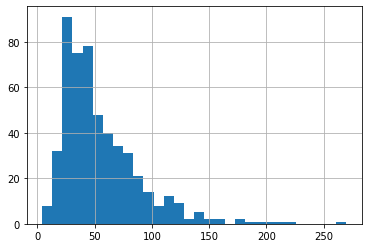

In [ ]:
train_text = [premises[i] + ' ' + hypotheses[i] for i in range(len(premises))]
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

### Data Preprocessing

In [ ]:
MAXLENGTH = 200

class ConvEntailProcessor():
    def __init__(self, tokenizer, args=None):

        test_size = 0.15
        if args is not None:
            test_size = args.test_size

        self.tokenizer = tokenizer
        self.double_sep = 'roberta' in tokenizer.name_or_path
        self.cls_token = tokenizer.cls_token
        self.sep_token = tokenizer.sep_token

        all_premises, all_hypotheses, all_labels = formulate_conv_entail(load_data(dataset='conv_entail')[0])
        self.train_premises, self.val_premises, self.train_hypotheses, self.val_hypotheses, \
        self.train_labels, self.val_labels = train_test_split(all_premises, all_hypotheses, 
                                                               all_labels, random_state=SEED, test_size=test_size)
        self.test_premises, self.test_hypotheses = get_conv_detail_testdata(load_data(dataset='conv_entail')[1])
        
    def truncate_seq_pair(self, token_a, token_b, max_len=MAXLENGTH-3):
        """
        Truncates a sequence pair in place to the maximum length.

        This is a simple heuristic which will always truncate the longer sequence one token at a time.
        This makes more sense than truncating an equal percent of tokens from each,
        since if one sequence is very short then each token that's truncated
        likely contains more information than a longer sequence.

        However, since we'd better not to remove tokens of options and questions,
        you can choose to use a bigger length or only pop from context
        """

        while True:
            total_length = len(token_a) + len(token_b)
            if total_length <= max_len:
                break
            if len(token_a) > len(token_b):
                token_a.pop()
            else:
                warning = 'Attention! you are removing from token_b (swag task is ok). ' \
                          'If you are training ARC and RACE (you are popping question + options), ' \
                          'you need to try to use a bigger max seq length!'
                print(warning)
                token_b.pop()

    def tokenize_and_encode(self, prev, next, max_len=MAXLENGTH):
        """
        Tokenize all of the sentences and map the tokens to their word IDs.
        Max is 512 if using BERT-based models, higher for longformer (2000+)
        """

        num_seps = 1
        extra_tokens = 3
        if self.double_sep:
            num_seps += 1
            extra_tokens += 1

        token_a = self.tokenizer.tokenize(prev)
        token_b = self.tokenizer.tokenize(next)
        self.truncate_seq_pair(token_a, token_b, max_len-extra_tokens)

        token_a = [self.cls_token] + token_a + ([self.sep_token] * num_seps)
        token_type_ids = [0] * len(token_a)
        token_b = token_b + [self.sep_token]
        token_type_ids += [1] * len(token_b)
        tokens = token_a + token_b

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        mask = [1] * len(input_ids)

        padding_length = max_len - len(input_ids)
        input_ids += ([0] * padding_length)
        mask += ([0] * padding_length)
        token_type_ids += ([0] * padding_length)

        assert len(input_ids) == max_len
        assert len(token_type_ids) == max_len
        assert len(mask) == max_len
            
        return input_ids, token_type_ids, mask

    def load_features(self, split='train'):

        if split == 'train':
            pre, hypo, labels = self.train_premises, self.train_hypotheses, self.train_labels
        elif split == 'val':
            pre, hypo, labels = self.val_premises, self.val_hypotheses, self.val_labels
        else:
            pre, hypo = self.test_premises, self.test_hypotheses
            seqs, segs, masks, lengths = [], [], [], []
            for prev, next in zip(pre, hypo):
              seq, seg, mask = self.tokenize_and_encode(prev, next)
              seqs.append(seq)
              segs.append(seg)
              masks.append(mask)

            seqs = torch.tensor(seqs)
            segs = torch.tensor(segs)
            masks = torch.tensor(masks)

            dataset = TensorDataset(seqs, masks, segs)
            return dataset, lengths
            

        seqs, segs, masks, lengths = [], [], [], []
        for prev, next in zip(pre, hypo):
          seq, seg, mask = self.tokenize_and_encode(prev, next)
          seqs.append(seq)
          segs.append(seg)
          masks.append(mask)

        labels = torch.tensor(labels)
        seqs = torch.tensor(seqs)
        segs = torch.tensor(segs)
        masks = torch.tensor(masks)

        dataset = TensorDataset(seqs, masks, segs, labels)

        return dataset, lengths

## Knowledge Dataset

PIQA


In [ ]:
!wget https://storage.googleapis.com/ai2-mosaic/public/physicaliqa/physicaliqa-train-dev.zip
!unzip physicaliqa-train-dev.zip

--2020-12-15 07:41:52--  https://storage.googleapis.com/ai2-mosaic/public/physicaliqa/physicaliqa-train-dev.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 172.217.164.144, 142.250.73.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1824009 (1.7M) [application/zip]
Saving to: ‘physicaliqa-train-dev.zip’

physicaliqa-train-d 100%[===================>]   1.74M  --.-KB/s    in 0.01s   

2020-12-15 07:41:52 (179 MB/s) - ‘physicaliqa-train-dev.zip’ saved [1824009/1824009]

Archive:  physicaliqa-train-dev.zip
   creating: physicaliqa-train-dev/
  inflating: physicaliqa-train-dev/train.jsonl  
  inflating: physicaliqa-train-dev/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/physicaliqa-train-dev/
  inflating: __MACOSX/physicaliqa-train-dev/._.DS_Store  
  inflating: physicaliqa-train-dev/train-labels.lst  
  inflating: physicaliqa-train-dev/de

In [ ]:
def load_piqa(preview=False):
    
    file_name = 'physicaliqa-train-dev/train.jsonl'
    df = pd.read_json(path_or_buf=file_name, lines=True)
    with open('physicaliqa-train-dev/train-labels.lst') as f:
      labels = [int(i) for i in list(f.read().splitlines())]
    df['labels'] = labels

    if preview:
        print(len(df))
        row = df.iloc[[preview]]
        print(row['goal'])
        print(row['sol1'])
        print(row['sol2'])
        print(row['labels'])
    return df

In [ ]:
df = load_piqa(preview=1)

16113
1    To permanently attach metal legs to a chair, y...
Name: goal, dtype: object
1    Weld the metal together to get it to stay firm...
Name: sol1, dtype: object
1    Nail the metal together to get it to stay firm...
Name: sol2, dtype: object
1    0
Name: labels, dtype: int64


### Data Preprocessing

In [ ]:
class PIQAProcessor():
    """
    Load the processed SWAG dataset
    max(size) = 73546
    """
    def __init__(self, tokenizer, args=None):
        self.test_size = 0.15
        if args is not None:
            self.test_size = args.test_size

        self.tokenizer = tokenizer
        self.double_sep = 'roberta' in tokenizer.name_or_path
        self.cls_token = tokenizer.cls_token
        self.sep_token = tokenizer.sep_token

        self.df = load_piqa()
    
    def truncate_seq_pair(self, token_a, token_b, max_len=MAXLENGTH-3):
        """
        Truncates a sequence pair in place to the maximum length.

        This is a simple heuristic which will always truncate the longer sequence one token at a time.
        This makes more sense than truncating an equal percent of tokens from each,
        since if one sequence is very short then each token that's truncated
        likely contains more information than a longer sequence.

        However, since we'd better not to remove tokens of options and questions,
        you can choose to use a bigger length or only pop from context
        """

        while True:
            total_length = len(token_a) + len(token_b)
            if total_length <= max_len:
                break
            if len(token_a) > len(token_b):
                token_a.pop()
            else:
                warning = 'Attention! you are removing from token_b (swag task is ok). ' \
                          'If you are training ARC and RACE (you are popping question + options), ' \
                          'you need to try to use a bigger max seq length!'
                print(warning)
                token_b.pop()

    def tokenize_and_encode(self, prev, next, max_len=MAXLENGTH):
        """
        Tokenize all of the sentences and map the tokens to their word IDs.
        Max is 512 if using BERT-based models, higher for longformer (2000+)
        """

        num_seps = 1
        extra_tokens = 3
        if self.double_sep:
            num_seps += 1
            extra_tokens += 1

        token_a = self.tokenizer.tokenize(prev)
        token_b = self.tokenizer.tokenize(next)
        self.truncate_seq_pair(token_a, token_b, max_len-extra_tokens)

        token_a = [self.cls_token] + token_a + ([self.sep_token] * num_seps)  
        token_type_ids = [0] * len(token_a)
        token_b = token_b + [self.sep_token]
        token_type_ids += [1] * len(token_b)
        tokens = token_a + token_b

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        mask = [1] * len(input_ids)

        padding_length = max_len - len(input_ids)
        input_ids += ([0] * padding_length)
        mask += ([0] * padding_length)
        token_type_ids += ([0] * padding_length)

        assert len(input_ids) == max_len
        assert len(token_type_ids) == max_len
        assert len(mask) == max_len
            
        return input_ids, token_type_ids, mask

    def load_features(self, size=16113):

        print("Creating features from dataset...")
        labels, seqs, segs, masks = [], [], [], []
        for row in df.iterrows():

            label = row[1]['labels']
            goal = row[1]['goal']
            sol1 = row[1]['sol1']
            sol2 = row[1]['sol2']

            if label == 0:
                seq, seg, mask = self.tokenize_and_encode(goal, sol1)
                seqs.append(seq)
                segs.append(seg)
                masks.append(mask)
                labels.append(1)

                seq, seg, mask = self.tokenize_and_encode(goal, sol2)
                seqs.append(seq)
                segs.append(seg)
                masks.append(mask)
                labels.append(0)
            else:
                seq, seg, mask = self.tokenize_and_encode(goal, sol1)
                seqs.append(seq)
                segs.append(seg)
                masks.append(mask)
                labels.append(0)

                seq, seg, mask = self.tokenize_and_encode(goal, sol2)
                seqs.append(seq)
                segs.append(seg)
                masks.append(mask)
                labels.append(1)
                        
            size -= 1
            if size == 0:
                break

        train_seq, val_seq, train_seg, val_seg, train_mask, val_mask, train_labels, val_labels = train_test_split(
            seqs, segs, masks, labels, random_state=SEED, test_size=self.test_size, stratify=labels)
        
        train_seq = torch.tensor(train_seq)
        val_seq = torch.tensor(val_seq)
        train_seg = torch.tensor(train_seg)
        val_seg = torch.tensor(val_seg)
        train_mask = torch.tensor(train_mask)
        val_mask = torch.tensor(val_mask)
        train_labels = torch.tensor(train_labels)
        train_y = torch.tensor(train_labels)
        val_y = torch.tensor(val_labels)

        train_data = TensorDataset(train_seq, train_mask, train_seg, train_y)
        val_data = TensorDataset(val_seq, val_mask, val_seg, val_y)

        return train_data, val_data


# Experiment

## Pre-trained Model

Self-designed model for flexibility.

In [ ]:
class MyBertClassifier(torch.nn.Module):

    def __init__(self, model_name='bert-base-uncased', num_labels=1, dropout_rate=0.2, freeze=False):
        super(MyBertClassifier, self).__init__()
        
        if num_labels == 1:
            self.loss_fct = torch.nn.BCEWithLogitsLoss()
        else:
            self.loss_fct = torch.nn.CrossEntropyLoss()
        self.bert = BertModel.from_pretrained(model_name)
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(self.num_embed(model_name), 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, num_labels)

        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False

    def num_embed(self, model_name):
        embedding_size = {
            'bert-base-uncased': 768,
            'bert-large-uncased': 1024
        }
        return embedding_size[model_name]

    def forward(self, input_ids, attention_mask, token_type_ids, labels=None):

        out = self.bert(input_ids=input_ids, 
                        attention_mask=attention_mask, 
                        token_type_ids=token_type_ids)
        x = out.pooler_output
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)

        loss = None
        if labels is not None:
            # x = np.argmax(x, axis=1)
            loss = self.loss_fct(x.flatten(), labels.float())
        
        return loss, x


class MyRobertaClassifier(torch.nn.Module):

    def __init__(self, model_name='roberta-base', num_labels=2, dropout_rate=0.2, freeze=False):
        super(MyRobertaClassifier, self).__init__()
        
        if num_labels == 1:
            self.loss_fct = torch.nn.BCEWithLogitsLoss()
        else:
            self.loss_fct = torch.nn.CrossEntropyLoss(torch.tensor([0.5,0.5],dtype=torch.float).to(DEVICE))
        self.roberta = RobertaModel.from_pretrained(model_name)
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(self.num_embed(model_name), 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, num_labels)

        if freeze:
            for param in self.roberta.parameters():
                param.requires_grad = False

    def num_embed(self, model_name):
        embedding_size = {
            'roberta-base': 768,
            'roberta-large': 1024,
        }
        return embedding_size[model_name]

    def forward(self, input_ids, attention_mask, token_type_ids, labels=None):

        out = self.roberta(input_ids=input_ids, 
                           attention_mask=attention_mask, 
                           token_type_ids=None)
        x = out.pooler_output
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        
        loss = None
        if labels is not None:
            # x = np.argmax(x, axis=1)
            loss = self.loss_fct(x, labels)
        
        return loss, x


class myRoberta_mnliClassifier(torch.nn.Module):

    def __init__(self, pretrained_model, num_labels=2, freeze=False):
        super(myRoberta_mnliClassifier, self).__init__()
        
        if num_labels == 1:
            self.loss_fct = torch.nn.BCEWithLogitsLoss()
        else:
            self.loss_fct = torch.nn.NLLLoss(torch.tensor([0.55,0.45],dtype=torch.float).to(DEVICE))
        self.roberta = pretrained_model
        self.softmax = torch.nn.Softmax(dim=1)

        if freeze:
            for param in self.roberta.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask, token_type_ids, labels=None):

        out = self.roberta(input_ids=input_ids, 
                           attention_mask=attention_mask, 
                           token_type_ids=None,
                           labels=labels)
        
        x = out[0] if labels is None else out[1]
        x = self.softmax(x)
        x = torch.stack((1-x[:,2],x[:,2]),dim=1)
        x = torch.log(x)
        
        loss = None
        if labels is not None:
            # x = np.argmax(x, axis=1)
            loss = self.loss_fct(x, labels)
        
        return loss, x

## Runtime

Training and evaluation functions.

In [ ]:
def fine_tune(args, model, tokenizer):

    processor = PIQAProcessor(tokenizer, args)
    dataset_tr, dataset_val = processor.load_features(size=args.pretrain_size)

    print('\n Loading training dataset')
    sampler_tr = RandomSampler(dataset_tr)
    dataloader_tr = DataLoader(dataset_tr, sampler=sampler_tr, batch_size=args.batch_size)

    print('\n Loading validation dataset')
    sampler_val = SequentialSampler(dataset_val)
    dataloader_val = DataLoader(dataset_val, sampler=sampler_val, batch_size=args.batch_size)

    model, optimizer, scheduler = load_optimizer(args, model, len(dataloader_tr), args.learning_rate_tune)

    tr_loss = 0.00
    num_steps = 0

    model.train()
    train_iterator = trange(int(args.num_train_epochs), desc="Epoch", disable=False, leave=True, position=1)

    for _ in train_iterator:
        disable = False
        if len(dataloader_tr) > 1000:
            disable = True
        epoch_iterator = tqdm(dataloader_tr, desc="Iteration", disable=disable, leave=True, position=1)
        for step, batch in enumerate(epoch_iterator):

            model.train()

            batch = tuple(b.to(args.device) for b in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args.model_type in ['bert', 'xlnet'] else None,
                      'labels': batch[3]}

            model.zero_grad()
            outputs = model(**inputs)
            loss = outputs[0]

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            tr_loss += loss.item()

            optimizer.step()
            scheduler.step()
            
            num_steps += 1

            if args.logging_steps_tune > 0 and num_steps % args.logging_steps_tune == 0:
                results = evaluate(args, model, dataloader_val)
                print("\n val acc: {}, val loss: {}"
                      .format(str(results['val_acc']), str(results['val_loss'])))

    loss = tr_loss / num_steps

    return model


def train(args, model, tokenizer):
    train_epoch = 1
    
    processor = ConvEntailProcessor(tokenizer, args)
    dataset_tr, lengths_tr = processor.load_features(split='train')
    dataset_val, lengths_val = processor.load_features(split='val')

    print('\n Loading training dataset')
    sampler_tr = RandomSampler(dataset_tr)
    dataloader_tr = DataLoader(dataset_tr, sampler=sampler_tr, batch_size=args.batch_size)

    print('\n Loading validation dataset')
    sampler_val = SequentialSampler(dataset_val)
    dataloader_val = DataLoader(dataset_val, sampler=sampler_val, batch_size=args.batch_size)

    num_steps = 0
    best_steps = 0
    tr_loss = 0.0
    best_val_acc, best_val_loss = 0.0, 99999999999.0
    best_model = None

    _, optimizer, scheduler = load_optimizer(args, model, len(dataloader_tr), args.learning_rate)

    model.train()
    train_iterator = trange(int(train_epoch), desc="Epoch", disable=False, leave=True, position=1)

    for _ in train_iterator:
      epoch_iterator = tqdm(dataloader_tr, desc="Iteration", disable=False, leave=True, position=1)
      for step, batch in enumerate(epoch_iterator):

          batch = tuple(b.to(args.device) for b in batch)
          inputs = {'input_ids': batch[0],
                    'attention_mask': batch[1],
                    'token_type_ids': batch[2] if args.model_type in ['bert', 'xlnet'] else None,
                    'labels': batch[3]}
          model.zero_grad()
          outputs = model(**inputs)

          
          loss = outputs[0]

          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          tr_loss += loss.item()

          optimizer.step()
          scheduler.step()
          
          num_steps += 1

          if args.logging_steps > 0 and num_steps % args.logging_steps == 0:
              results, tn, fn = evaluate(args, model, dataloader_val, lengths_val)
              
              print("\n how many 0 is predicted 0: {}, how many 1 is predicted 0: {}, val acc: {}, val loss: {}"
                    .format(str(tn), str(fn), str(results['val_acc']), str(results['val_loss'])))
              if results["val_loss"] < best_val_loss:
                  best_val_acc, best_val_loss = results["val_acc"], results["val_loss"]
                  best_steps = num_steps
                  best_model = deepcopy(model)
      loss = tr_loss / num_steps
      print(loss)

    results, tn, fn = evaluate(args, model, dataloader_tr, lengths_tr)
    print("\n how many 0 is predicted 0: {}, how many 1 is predicted 0: {}, train acc: {}, train loss: {}"
                      .format(str(tn), str(fn), str(results['val_acc']), str(results['val_loss'])))
    print("\n Best val acc: {}, Best val loss: {}".format(best_val_acc, best_val_loss))

    return best_model


def evaluate(args, model, dataloader, lengths=None):

    val_loss = 0.0
    num_steps = 0
    preds, labels = None, None

    results = {}

    for batch in tqdm(dataloader, desc="Validation", disable=True, leave=True, position=1):
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args.model_type in ['bert', 'xlnet'] else None,
                      'labels': batch[3]}
            
            outputs = model(**inputs)
            logits = outputs[1]

            loss = outputs[0]
 
            val_loss += loss.mean().item()

        num_steps += 1

        if preds is None:
            preds = logits.detach().cpu().numpy()
            labels = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            labels = np.append(labels, inputs['labels'].detach().cpu().numpy(), axis=0)

    loss = val_loss / num_steps
    preds = np.argmax(preds, axis=1)
    acc = accuracy_score(preds, labels)
    result = {"val_acc": acc, "val_loss": loss}
    results.update(result)

    tn, fp, fn, tp = confusion_matrix(labels, preds, normalize='true').ravel()
    # classification_report(labels, preds)

    return results, tn, fn
    # how many 0 is truely predicted 0:tn
    # how many 1 is falsely predicted 0:fn


def test(args, tokenizer, model):

    processor = ConvEntailProcessor(tokenizer, args)
    dataset_val, lengths_val = processor.load_features(split='val')
    sampler_val = SequentialSampler(dataset_val)
    dataloader_val = DataLoader(dataset_val, sampler=sampler_val, batch_size=args.batch_size)
    results, tn, fn = evaluate(args, model, dataloader_val, lengths_val)
    
    print("\n how many 0 is predicted 0: {}, how many 1 is predicted 0: {}, val acc: {}, val loss: {}"
                      .format(str(tn), str(fn), str(results['val_acc']), str(results['val_loss'])))
    

def test_on_test_dataset(args, tokenizer, model):

    processor = ConvEntailProcessor(tokenizer, args)
    dataset_test, lengths_test = processor.load_features(split='test')
    sampler_test = SequentialSampler(dataset_test)
    dataloader_test = DataLoader(dataset_test, sampler=sampler_test, batch_size=args.batch_size)
    
    val_loss = 0.0
    num_steps = 0
    preds, labels = None, None

    results = {}

    for batch in tqdm(dataloader_test, desc="Validation", disable=True, leave=True, position=1):
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args.model_type in ['bert', 'xlnet'] else None,
                      'labels': None}
            
            outputs = model(**inputs)
            logits = outputs[1]

        num_steps += 1

        if preds is None:
            preds = logits.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)


    preds = np.argmax(preds, axis=1)
    out = preds.tolist()
    out_file = open("/content/temp_preds.json", 'w')
    json.dump(out, out_file)
    out_file.close()
    
    print("Test over. File should have been written.")

In [ ]:
def main(args):
    print('Using device', args.device)
    print('Using model', args.model_type)
    set_seed(args.seed)

    num_labels = 2

    config = AutoConfig.from_pretrained(args.model_name)
    tokenizer = AutoTokenizer.from_pretrained(args.model_name)
    
    pretrained_model = AutoModelForSequenceClassification.from_pretrained(args.model_name)
    # model = MyBertClassifier(model_name=args.config_name, num_labels=1)
    # model = MyRobertaClassifier()
    model = myRoberta_mnliClassifier(pretrained_model)

    model.to(args.device)

    print('\nTuning...')
    #model = fine_tune(args, model, tokenizer)
    # model = freeze(model, args.model_name)

    print('\nTraining...')
    best_model = train(args, model, tokenizer)

    print('\nTesting...')
    test_on_test_dataset(args, tokenizer, best_model)

    return best_model

The default model is based on `bert`, and
```
parser.add_argument("--model_name", type=str, default='bert-base-uncased',
                    help="Path to pre-trained model or shortcut name. See https://huggingface.co/models")
```

This would leads to

```
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using custom data configuration default
```

Should check https://huggingface.co/models for other models.

Setup parameters.

In [ ]:
def run(model_type='bert',
        model_name='bert-base-uncased',
        task_name=None,
        batch_size=64,
        lr=1e-5,
        lr_tune=1e-5,
        epochs=1,
        pretrain_size=1000,
        logging_steps=50,
        logging_steps_tune=200):
  
    parser = argparse.ArgumentParser(description="Common sense question answering")
    parser.add_argument("--model_type", type=str, default=model_type,
                        help="Model: <str> [ bert | xlnet | roberta | gpt2 ]")
    parser.add_argument("--task_name", default=task_name, type=str, required=False,
                        help="The name of the task to train: <str> [ commonqa ]")
    parser.add_argument("--model_name", type=str,
                        default=model_name,
                        help="Path to pre-trained model or shortcut name."
                              "See https://huggingface.co/models")
    parser.add_argument("--config_name", type=str,
                        default=model_name,
                        help="Pre-trained config name or path")
    parser.add_argument("--tokenizer_name", default=model_name, type=str,
                        help="Pre-trained tokenizer name or path if not the same as model_name")

    parser.add_argument("--max_seq_length", default=100, type=int,
                        help="The maximum total input sequence length after tokenization. "
                                "Sequences longer than this will be truncated, sequences shorter will be padded.")
    parser.add_argument("--batch_size", default=batch_size, type=int,
                        help="Batch size for training.")

    parser.add_argument("--learning_rate", default=lr, type=float,
                        help="The initial learning rate for Adam.")
    parser.add_argument("--learning_rate_tune", default=lr_tune, type=float,
                        help="The initial learning rate for Adam.")
    parser.add_argument("--weight_decay", default=0.0, type=float,
                        help="Weight decay if we apply some.")
    parser.add_argument("--adam_epsilon", default=1e-8, type=float,
                        help="Epsilon for Adam optimizer.")
    parser.add_argument("--test_size", default=0.2, type=float,
                        help="The ratio of size of validation set")
    parser.add_argument("--pretrain_size", default=pretrain_size, type=float,
                        help="The ratio of size of validation set")
        
    parser.add_argument("--num_train_epochs", default=epochs, type=int,
                        help="Total number of training epochs to perform.")
    parser.add_argument("--warmup_steps", default=epochs//6+2, type=int,
                        help="Linear warmup over warmup_steps.")
    parser.add_argument('--logging_steps', type=int, default=logging_steps,
                        help="Log every n updates steps.")
    parser.add_argument('--logging_steps_tune', type=int, default=logging_steps_tune,
                        help="Log every n updates steps.")

    parser.add_argument('--fp16', type=bool, default=True,
                        help="Whether to use 16-bit (mixed) precision (through NVIDIA apex) instead of 32-bit")
    parser.add_argument('--opt_level', type=str, default='O1',
                        help="For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']."
                              "See details at https://nvidia.github.io/apex/amp.html")

    parser.add_argument("--seed", type=int, default=0, help="Random seed: <int>")
    parser.add_argument("--device", default=DEVICE)
    args, unknown = parser.parse_known_args()
    best_model = main(args)
    return best_model

## Finetuning

### RoBerta

Check this for `</s>` rules: https://github.com/pytorch/fairseq/issues/1654

I may have got it wrong. Check `Data Preprocessing` sections.

In [ ]:
import torch
torch.cuda.empty_cache()

Try `roberta-large-mnli`, but this one has a `neutral` label (`num_labels = 3`).

There is an [online entailment](https://huggingface.co/roberta-large-mnli?text=John+grabbed+the+ladder+and+put+it+in+his+truck.+%3C%2Fs%3E%3C%2Fs%3E+John+put+a+drill+and+rope+in+the+bucket+and+also+put+that+in+this+truck) model to play with.

In [ ]:
# Try roberta-large-mnli
model_type = 'roberta'
model_name = 'roberta-large-mnli'
task_name = 'mnli'
batch_size = 8
epochs = 1
lr_tune = 1e-6
lr = 5e-6
# pretrain_size = 73546
pretrain_size = 50
logging_steps = 25
logging_steps_tune = 50

best_model = run(model_type, model_name, task_name, batch_size, lr, lr_tune, epochs, pretrain_size, logging_steps, logging_steps_tune)

Using device cuda
Using model roberta


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Tuning...

Training...

 Loading training dataset

 Loading validation dataset



Iteration:  48%|████▊     | 25/52 [00:31<01:08,  2.53s/it]


 how many 0 is predicted 0: 0.5106382978723404, how many 1 is predicted 0: 0.2631578947368421, val acc: 0.6346153846153846, val loss: 0.6519540892197535



Iteration:  96%|█████████▌| 50/52 [01:05<00:05,  2.72s/it]


 how many 0 is predicted 0: 0.574468085106383, how many 1 is predicted 0: 0.2631578947368421, val acc: 0.6634615384615384, val loss: 0.6281949694340045



Iteration: 100%|██████████| 52/52 [01:08<00:00,  1.31s/it]

Epoch: 100%|██████████| 1/1 [01:08<00:00, 68.03s/it]


0.6233969749166415

 how many 0 is predicted 0: 0.7015706806282722, how many 1 is predicted 0: 0.13777777777777778, train acc: 0.7884615384615384, train loss: 0.4386906801508023

 Best val acc: 0.6634615384615384, Best val loss: 0.6281949694340045

Testing...
Test over. File should have been written.


## Wrap Up
Format the prediction into the json file we need.

In [ ]:
test_file = '/content/drive/Shareddrives/EECS595-Fall2020/Final_Project_Common/Conversational_Entailment/test_set_unlabeled.json'
preds_file = '/content/temp_preds.json'
test_data = codecs.open(test_file, 'r', encoding='utf-8').read()
preds = codecs.open(preds_file, 'r', encoding='utf-8').read()
data = json.loads(test_data)
ids = [item["id"] for item in data]
preds = json.loads(preds)

results = [{"id": ids[i], "pred": preds[i]} for i in range(len(ids))]
out_file = open("/content/ConvEnt_team2_preds.json", 'w')
json.dump(results, out_file)
out_file.close()

print("Generated the submission file!")

Generated the submission file!


# References

[1] Reimers, N., & Gurevych, I. (2019). Sentence-bert: Sentence embeddings using siamese bert-networks. arXiv preprint arXiv:1908.10084.

[2] Zellers, R., Bisk, Y., Schwartz, R., & Choi, Y. (2018). Swag: A large-scale adversarial dataset for grounded commonsense inference. arXiv preprint arXiv:1808.05326.